In [21]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

PseudoData = pd.read_csv('PseudoData.csv')  #Read in CSV

# Preprocessing

In [22]:
PseudoData.loc[1, "Att Rate"] = np.NaN
PseudoData.loc[18, "Att Rate"] = np.NaN
PseudoData.loc[13, "#Honors semesters"] = np.NaN
PseudoData.loc[20, "GPA"] = np.NaN

In [29]:
DiscardedCount = open("demofile.txt", 'a')
DiscardedCount.write("Original Count/Shape:" + str(22))
DiscardedCount.write("\n\nNew Count/Shape:" + str(18))
DiscardedCount.close()

## Correlation Heatmap

In [163]:
PseudoData['#AP/Honors'] = PseudoData['#Honors semesters'] + PseudoData['#AP semesters']
PseudoData = PseudoData[['Student', 'Grade', 'GPA', '#AP/Honors', '#Honors semesters', '#AP semesters', 'Days Enrolled', 'Days Present', 'Att Rate']]
PseudoData['Days Absent'] = PseudoData['Days Enrolled'] - PseudoData['Days Present']
PseudoData = PseudoData[['Student', 'Grade', 'GPA', '#AP/Honors', '#Honors semesters', '#AP semesters', 'Days Absent', 'Days Enrolled', 'Days Present', 'Att Rate']]
PseudoData = PseudoData.drop(labels=['#Honors semesters', '#AP semesters','Days Present'], axis=1)

In [164]:
CorrelationDF = PseudoData.drop(labels=["Student", "Att Rate"], axis=1)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

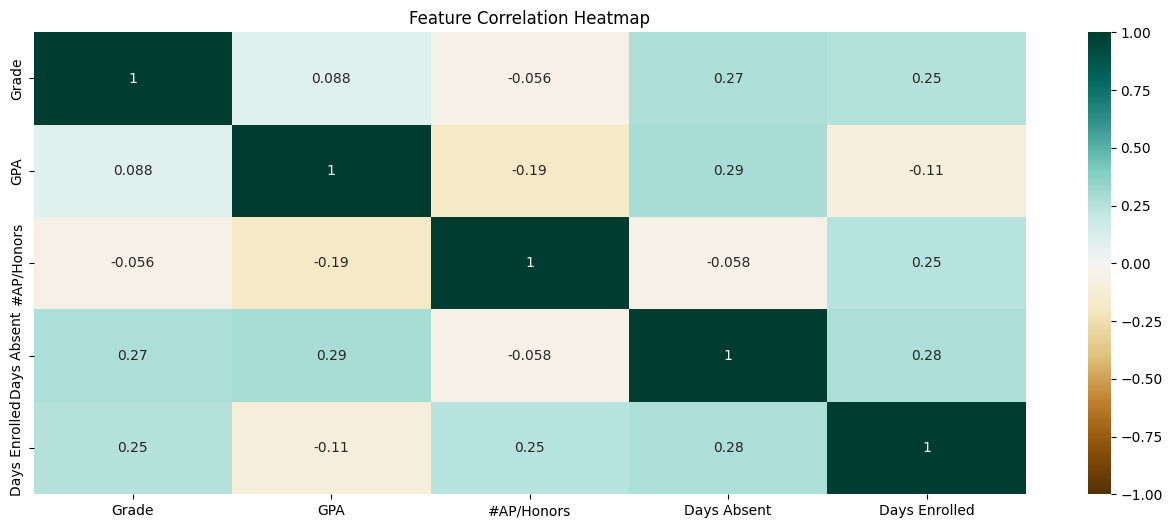

In [165]:
plt.figure(figsize=(16,6))
FeatureHeatMap = sns.heatmap(CorrelationDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
FeatureHeatMap.set_title('Feature Correlation Heatmap')


# Stacked Ensmeble Construction

## Base Models (Extra Trees, KNN, and XGB)

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [170]:
TrainingDF = PseudoData.drop(labels=["Student"], axis=1)

In [171]:
X = TrainingDF[['Grade', 'GPA', '#AP/Honors', 'Days Absent', 'Days Enrolled']]
y = TrainingDF[['Att Rate']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 44, test_size = 0.25, shuffle= True)
y_train = y_train.values.ravel()

### Extra Trees Regressor

In [172]:
etr = ExtraTreesRegressor(random_state=19)
etr.fit(X_train, y_train)

C:\Users\ishaa\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(random_state=19)

In [173]:
etr_y_pred = etr.predict(X_test)
etr_r2 = r2_score(y_test, etr_y_pred)
r2

0.875323252462644

In [174]:
etr_MAE = mean_absolute_error(y_test, etr_y_pred)
MAE

1.7027294486903888

In [175]:
etr_MSE = mean_squared_error(y_test, etr_y_pred)
MSE

5.05997116637372

### KNN

In [176]:
KNN = KNeighborsRegressor(3)
KNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [177]:
KNN_y_pred = KNN.predict(X_test)
KNN_r2 = r2_score(y_test, KNN_y_pred)
r2

0.875323252462644

In [178]:
KNN_MAE = mean_absolute_error(y_test, KNN_y_pred)
MAE

1.7027294486903888

In [179]:
KNN_MSE = mean_squared_error(y_test, KNN_y_pred)
MSE

5.05997116637372

### GBR

In [180]:
GBR = GradientBoostingRegressor(loss = 'absolute_error', subsample=0.5)
GBR.fit(X_train, y_train)

c:\Users\ishaa\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(loss='absolute_error', subsample=0.5)

In [181]:
GBR_y_pred = GBR.predict(X_test)
GBR_r2 = r2_score(y_test, GBR_y_pred)
r2

0.875323252462644

In [182]:
GBR_MAE = mean_absolute_error(y_test, GBR_y_pred)
MAE

1.7027294486903888

In [183]:
GBR_MSE = mean_squared_error(y_test, GBR_y_pred)
MSE

5.05997116637372

### Averaging layer 2

In [184]:
Layer_1_preds = pd.DataFrame({'Extra Trees Y predictions': etr_y_pred.flatten(), 'KNN Y predictions': KNN_y_pred.flatten(), 'GBR Y predictions': GBR_y_pred.flatten()})
Layer_1_preds

,Extra Trees Y predictions,KNN Y predictions,GBR Y predictions
0,89.127,90.200000,90.385263
1,78.015,83.233333,76.738784
2,94.843,94.800000,96.870108
3,88.655,89.233333,91.280380
4,94.637,94.700000,91.514994
5,84.228,89.233333,85.912183


In [185]:
y_pred_avgs = Layer_1_preds.mean(axis=1)
y_pred_avgs

0    89.904088
1    79.329039
2    95.504369
3    89.722904
4    93.617331
5    86.457839
dtype: float64

In [186]:
Averaged_r2 = r2_score(y_test, y_pred_avgs)
Averaged_MAE = mean_absolute_error(y_test, y_pred_avgs)
Averaged_MSE = mean_squared_error(y_test, y_pred_avgs)


In [187]:
Averaged_r2

0.9239510937835106

In [188]:
Averaged_MAE

1.3334846604129968

In [189]:
Averaged_MSE

3.0864237341000518

In [195]:
ErrorMetric_df = pd.DataFrame(data=[[etr_r2, etr_MAE, etr_MSE], 
                                    [KNN_r2, KNN_MAE, KNN_MSE], 
                                    [GBR_r2, GBR_MAE, GBR_MSE], 
                                    [Averaged_r2, Averaged_MAE, Averaged_MSE]], index=['Extra Trees', 'KNN', 'Gradient Boosting', 'Layer 2 Averaging'], columns=["R^2", "MAE", "MSQ"])

In [196]:
ErrorMetric_df

,R^2,MAE,MSQ
Extra Trees,0.974253,0.664167,1.044930
KNN,0.671319,2.416667,13.339444
Gradient Boosting,0.917614,1.728621,3.343600
Layer 2 Averaging,0.923951,1.333485,3.086424
